<font size="6">**Project definition**

<font size="4">This project aims to analyze the trends in burn area caused by wildfires across California. I utilize the dataset provided by Monitoring Trends in Burn Severity (MTBS) as the historical record of wildfires. This dataset includes only "large" wildfires that exceed 1,000 acres in Western states and 500 acres in Eastern states. </font>

<font size="5">**1. Import libraries**</font>

In [9]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

<font size="5">**2. Load the data**</font>

In [12]:
# Load the wildfire data from local disk
shapefile_path ='./mtbs_FODpoints_DD.shp'
mtbs = gpd.read_file(shapefile_path)

# extract the "year" from ignition date column
mtbs['year'] = mtbs['Ig_Date'].dt.year

# Display the first few rows
print(mtbs.head())

# check out the crs of MTBS
print(f'CRS of MTBS is {mtbs.crs}')

                Event_ID irwinID Incid_Name Incid_Type  Map_ID Map_Prog  \
0  AK6260315742119850801    None  CAMELBACK   Wildfire    4737     MTBS   
1  AK6256215664519850720    None  SUGARLOAF   Wildfire    4738     MTBS   
2  AK6547615382919850801    None  TAL NW 44   Wildfire    4739     MTBS   
3  AK6521015526519850803    None  GAL NE 48   Wildfire    4740     MTBS   
4  AZ3178311066219850302    None    UNNAMED   Wildfire    4741     MTBS   

  Asmnt_Type  BurnBndAc BurnBndLat BurnBndLon  ... dNBR_stdDv NoData_T  \
0   Extended       4780     62.603   -157.421  ...      -9999     -970   
1   Extended       5489     62.562   -156.645  ...      -9999     -970   
2   Extended       1491     65.476   -153.829  ...      -9999     -970   
3   Extended       1298     65.210   -155.265  ...      -9999     -970   
4    Initial       1326     31.783   -110.662  ...      -9999     -970   

  IncGreen_T Low_T  Mod_T  High_T                           Comment  ORIG_FID  \
0       -150   130    3

<font size="5">**3. Clip the dataset for California**</font>

In [18]:
## Load the shapefile of all US states
shapefile_path = "./cb_2022_us_state_20m.shp"
states_bnd = gpd.read_file(shapefile_path)

## Extract California boundary
CA_bnd = states_bnd[states_bnd['NAME'] == 'California']

# reproject MTBS fires to match that of California boundary's shapefile
mtbs_prj = mtbs.to_crs(CA_bnd.crs)

# clip MTBS across California's boundary
mtbs_CA = gpd.clip(mtbs_prj, CA_bnd)

<font size="5">**4. Visualization**

<font size="3">This section presents a series of maps illustrating all the fires in the MTBS dataset over each decade, beginning in 1985. Each point is scaled according to its burn area, allowing for a clear visual representation of wildfire intensity over time.</font> 

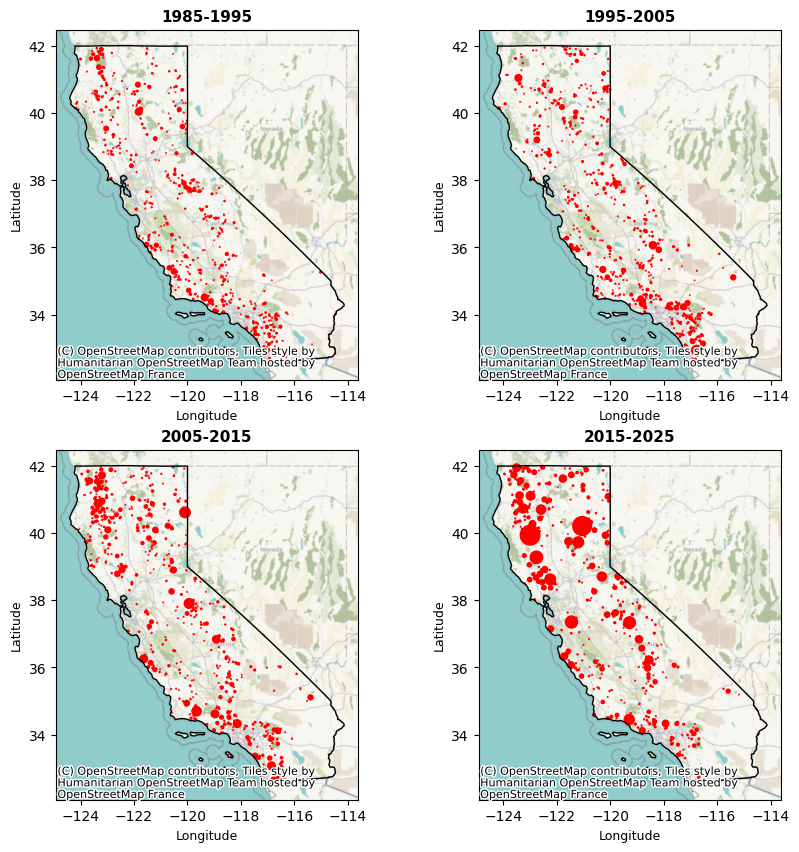

In [26]:
ys = [y for y in range(1985, 2017, 10)]
max_size = np.max(mtbs_CA['BurnBndAc']) # used to scale the marker size for each wildfire
cnt = 0
fig, axs = plt.subplots(2, 2, figsize=[10,10])
for i in [0,1]:
    for j in [0,1]:
        plt.subplot(2, 2, cnt+1)
        x = mtbs_CA.loc[mtbs_CA['year'].between(ys[cnt],ys[cnt]+10),:]
        x.plot(ax=axs[i,j], color='red', marker='o', markersize=200*pd.to_numeric(x['BurnBndAc'])/max_size, label='Locations')
        CA_bnd.plot(ax=axs[i,j], color='none')
        ctx.add_basemap(axs[i,j], crs = CA_bnd.crs.to_string())
        plt.title(f'{ys[cnt]}-{ys[cnt] + 10}', fontsize = 11, fontweight = 'bold')
        plt.xlabel('Longitude', fontsize = 9)
        plt.ylabel('Latitude', fontsize = 9)
        cnt += 1

plt.show()

<font size="3">It is evident that the burn areas have progressively increased over time. </font> 

<font size="3">To analyze the trend in burn area over the years, the following bar plot illustrates the non-overlapping 5-year moving average of burn area for the entire state.</font> 

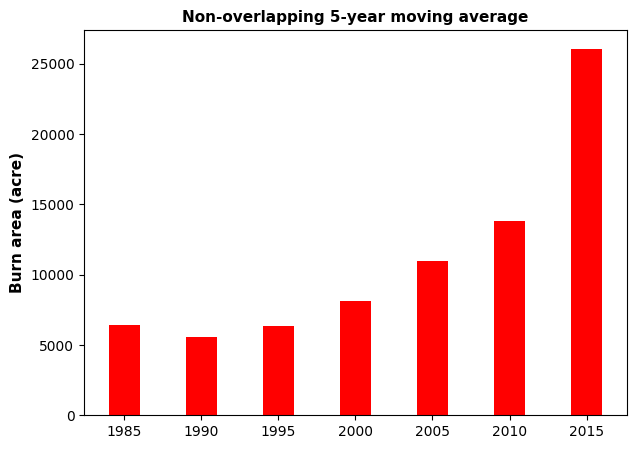

In [33]:
ys = [y for y in range(1985, 2017, 5)]
size = list()
for yr in ys:
    x = mtbs_CA.loc[mtbs_CA['year'].between(yr,yr+5),'BurnBndAc']
    size.append(np.average(x))
width = 2
plt.figure(figsize=(7, 5))
plt.bar(ys, size, color='r', width=width)
plt.ylabel('Burn area (acre)', fontsize = 11, fontweight = 'bold')
plt.title('Non-overlapping 5-year moving average', fontsize = 11, fontweight = 'bold')
plt.show()

<font size="3">The following plot illustrates the distribution of the 5-year moving average of burn area. Additionally, it highlights the minimum, maximum, and mean values. Please note that the y-axis is presented on a logarithmic scale to show the very large range of burn area.</font> 

([<matplotlib.axis.XTick at 0x29941f202c0>,
 [Text(1, 0, '1985'),
  Text(2, 0, '1990'),
  Text(3, 0, '1995'),
  Text(4, 0, '2000'),
  Text(5, 0, '2005'),
  Text(6, 0, '2010'),
  Text(7, 0, '2015')])

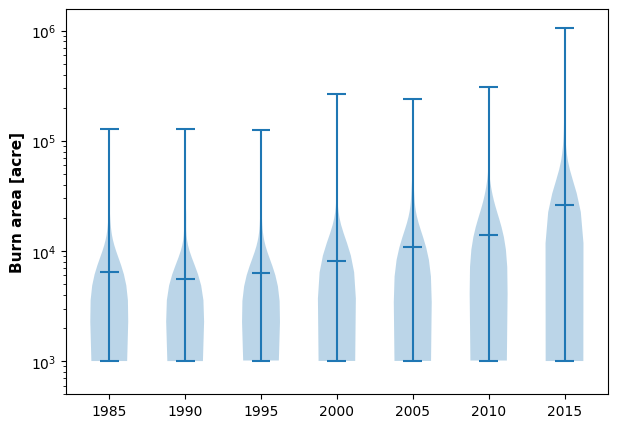

In [39]:
ys = [y for y in range(1985, 2017, 5)]
size = list()
plt.figure(figsize=(7, 5))
plt.yscale('log')
for yr in ys:
    x = mtbs_CA.loc[mtbs_CA['year'].between(yr,yr+5),'BurnBndAc']
    size.append(x)
plt.violinplot(size, showmeans=True)
plt.ylabel('Burn area [acre]', fontsize = 11, fontweight = 'bold')
plt.ylim(500, max_size+500000)
plt.xticks(range(1,8),ys)